In [1]:
!pip3 -qq install torch==0.4.1
!pip install -qq bokeh==0.13.0
!pip install -qq gensim==3.6.0

tcmalloc: large alloc 1073750016 bytes == 0x58dcc000 @  0x7fe1d929f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети, часть 2

## POS Tagging

Мы уже посмотрели на применение рекуррентных сетей для классификации.

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg =x250)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Перейдем к ещё одному варианту - sequence labeling (последняя картинка).

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.cross_validation import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADP', 'VERB', 'DET', 'NOUN', 'CONJ', 'ADJ', 'PRON', '.', 'X', 'NUM', 'PRT', 'ADV'}


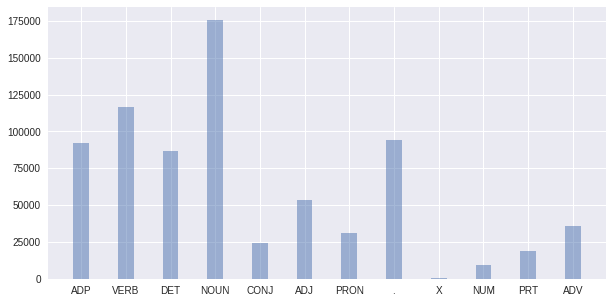

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png =x150)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Делаемся рекуррентнее

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png =x400)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [13]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch, y_batch

(array([[34628., 14750., 14270., 28768.],
        [17090., 12203.,   460., 24701.],
        [30266.,   462.,  9901., 34916.],
        [28768., 30914., 18986., 41509.],
        [ 5183., 32119., 30266.,   462.],
        [  462., 34426., 22808.,  1468.],
        [28768., 31402.,   462., 11961.],
        [38620., 20903., 25977., 23294.],
        [41044., 43688., 13008., 39582.],
        [10047., 28768., 28768., 10206.],
        [  462., 19888.,  8160.,   462.],
        [29898., 39819., 18845., 39582.],
        [ 8604.,   462., 28768.,  7917.],
        [10626.,  9834., 37950., 19336.],
        [    0., 24088., 17189.,   266.],
        [    0., 17427.,   462., 20307.],
        [    0., 41194., 28768.,   460.],
        [    0., 18845.,  4238., 27230.],
        [    0., 28768., 18845., 41050.],
        [    0., 35018., 37679.,  3142.],
        [    0., 18845., 24709., 30266.],
        [    0.,  2200., 42862., 15072.],
        [    0., 10626., 29534., 10626.],
        [    0.,     0., 35140.,  

**Задание** Реализуйте `LSTMTagger`:

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        return self._out_layer(self._lstm(self._emb(inputs))[0])

**Задание** Научитесь считать accuracy (а заодно проверьте, что модель работает)

In [15]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

preds = torch.argmax(logits, dim=-1)

correct_count = (preds == y_batch).float().sum().item()
total_count = np.prod(y_batch.shape).astype('float')
accuracy = (correct_count / total_count).item()

print('Accuracy = {:.2%}'.format(accuracy))

Accuracy = 3.12%


In [16]:
criterion = nn.CrossEntropyLoss()
criterion(logits.transpose(2, 1), y_batch)

tensor(2.5651, grad_fn=<NllLoss2DBackward>)

**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)
                cur_correct_count = (preds == y_batch).float().sum().item()
                cur_sum_count = np.prod(y_batch.shape).astype('float')

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [18]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.31951, Accuracy = 90.96%: 100%|██████████| 572/572 [00:15<00:00, 36.23it/s]
[1 / 20]   Val: Loss = 0.10774, Accuracy = 96.90%: 100%|██████████| 13/13 [00:00<00:00, 35.95it/s]
[2 / 20] Train: Loss = 0.10206, Accuracy = 96.80%: 100%|██████████| 572/572 [00:15<00:00, 34.48it/s]
[2 / 20]   Val: Loss = 0.07690, Accuracy = 97.93%: 100%|██████████| 13/13 [00:00<00:00, 35.53it/s]
[3 / 20] Train: Loss = 0.06832, Accuracy = 97.86%: 100%|██████████| 572/572 [00:15<00:00, 36.82it/s]
[3 / 20]   Val: Loss = 0.07002, Accuracy = 98.27%: 100%|██████████| 13/13 [00:00<00:00, 36.58it/s]
[4 / 20] Train: Loss = 0.05117, Accuracy = 98.38%: 100%|██████████| 572/572 [00:15<00:00, 36.59it/s]
[4 / 20]   Val: Loss = 0.06833, Accuracy = 98.42%: 100%|██████████| 13/13 [00:00<00:00, 36.34it/s]
[5 / 20] Train: Loss = 0.04108, Accuracy = 98.69%: 100%|██████████| 572/572 [00:15<00:00, 36.90it/s]
[5 / 20]   Val: Loss = 0.06911, Accuracy = 98.52%: 100%|██████████| 13/13 [00:00<00:00, 35.90it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [19]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

preds = torch.argmax(logits, dim=-1)

mask = (y_batch != 0).float()
correct_count = ((preds == y_batch).float() * mask).sum().item()
total_count = mask.sum().item()
accuracy = (correct_count / total_count)

print('Accuracy = {:.2%}'.format(accuracy))

Accuracy = 5.43%


In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
criterion(logits.transpose(2, 1), y_batch)

tensor(2.5934, grad_fn=<NllLoss2DBackward>)

In [0]:
def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)
                mask = (y_batch != 0).float()
                cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
                cur_sum_count = mask.sum().item()

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [22]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.68432, Accuracy = 78.37%: 100%|██████████| 572/572 [00:15<00:00, 36.21it/s]
[1 / 20]   Val: Loss = 0.36245, Accuracy = 88.30%: 100%|██████████| 13/13 [00:00<00:00, 35.03it/s]
[2 / 20] Train: Loss = 0.27451, Accuracy = 90.89%: 100%|██████████| 572/572 [00:15<00:00, 36.40it/s]
[2 / 20]   Val: Loss = 0.24577, Accuracy = 92.24%: 100%|██████████| 13/13 [00:00<00:00, 35.62it/s]
[3 / 20] Train: Loss = 0.18544, Accuracy = 93.87%: 100%|██████████| 572/572 [00:15<00:00, 35.44it/s]
[3 / 20]   Val: Loss = 0.19940, Accuracy = 93.90%: 100%|██████████| 13/13 [00:00<00:00, 35.60it/s]
[4 / 20] Train: Loss = 0.13808, Accuracy = 95.41%: 100%|██████████| 572/572 [00:15<00:00, 36.26it/s]
[4 / 20]   Val: Loss = 0.17781, Accuracy = 94.68%: 100%|██████████| 13/13 [00:00<00:00, 38.43it/s]
[5 / 20] Train: Loss = 0.10724, Accuracy = 96.41%: 100%|██████████| 572/572 [00:15<00:00, 36.51it/s]
[5 / 20]   Val: Loss = 0.16920, Accuracy = 94.92%: 100%|██████████| 13/13 [00:00<00:00, 34.57it/s]


**Задание** Посчитайте качество модели на тесте

In [23]:
do_epoch(model, criterion, (X_test, y_test), 256)

      Loss = 0.28378, Accuracy = 95.28%: 100%|██████████| 56/56 [00:01<00:00, 54.00it/s]


(0.2837821585791452, 0.9527763720052742)

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png =x450)  
from [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)

**Задание** Добавьте Bidirectional LSTM.

In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._emb = nn.Embedding(vocab_size, word_emb_dim)
        self._lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self._out_layer = nn.Linear(lstm_hidden_dim * 2, tagset_size)

    def forward(self, inputs):
        return self._out_layer(self._lstm(self._emb(inputs))[0])

In [25]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 20] Train: Loss = 0.55103, Accuracy = 82.46%: 100%|██████████| 572/572 [00:19<00:00, 28.27it/s]
[1 / 20]   Val: Loss = 0.27885, Accuracy = 91.06%: 100%|██████████| 13/13 [00:00<00:00, 29.47it/s]
[2 / 20] Train: Loss = 0.20631, Accuracy = 93.43%: 100%|██████████| 572/572 [00:19<00:00, 29.50it/s]
[2 / 20]   Val: Loss = 0.17814, Accuracy = 94.39%: 100%|██████████| 13/13 [00:00<00:00, 29.02it/s]
[3 / 20] Train: Loss = 0.13118, Accuracy = 95.96%: 100%|██████████| 572/572 [00:19<00:00, 29.40it/s]
[3 / 20]   Val: Loss = 0.14404, Accuracy = 95.45%: 100%|██████████| 13/13 [00:00<00:00, 29.36it/s]
[4 / 20] Train: Loss = 0.08945, Accuracy = 97.26%: 100%|██████████| 572/572 [00:19<00:00, 28.69it/s]
[4 / 20]   Val: Loss = 0.12853, Accuracy = 96.06%: 100%|██████████| 13/13 [00:00<00:00, 29.34it/s]
[5 / 20] Train: Loss = 0.06185, Accuracy = 98.15%: 100%|██████████| 572/572 [00:20<00:00, 28.56it/s]
[5 / 20]   Val: Loss = 0.11728, Accuracy = 96.40%: 100%|██████████| 13/13 [00:00<00:00, 29.04it/s]


In [26]:
do_epoch(model, criterion, (X_test, y_test), 256)

      Loss = 0.18093, Accuracy = 96.79%: 100%|██████████| 56/56 [00:01<00:00, 41.66it/s]


(0.18092933988996915, 0.9679001890046787)

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [27]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [28]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._embs = nn.Embedding.from_pretrained(embeddings)
        self._lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)
        
    def forward(self, inputs):
        if isinstance(inputs, LongTensor):
            embs = self._embs(inputs)
        else:
            embs = inputs
        return self._out_layer(self._lstm(embs)[0])

In [30]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=FloatTensor(embeddings),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.76694, Accuracy = 77.47%: 100%|██████████| 572/572 [00:11<00:00, 47.71it/s]
[1 / 50]   Val: Loss = 0.37361, Accuracy = 89.00%: 100%|██████████| 13/13 [00:00<00:00, 39.27it/s]
[2 / 50] Train: Loss = 0.28320, Accuracy = 91.54%: 100%|██████████| 572/572 [00:12<00:00, 47.65it/s]
[2 / 50]   Val: Loss = 0.25508, Accuracy = 92.19%: 100%|██████████| 13/13 [00:00<00:00, 40.61it/s]
[3 / 50] Train: Loss = 0.20778, Accuracy = 93.59%: 100%|██████████| 572/572 [00:11<00:00, 47.69it/s]
[3 / 50]   Val: Loss = 0.20888, Accuracy = 93.43%: 100%|██████████| 13/13 [00:00<00:00, 37.87it/s]
[4 / 50] Train: Loss = 0.17279, Accuracy = 94.55%: 100%|██████████| 572/572 [00:11<00:00, 46.18it/s]
[4 / 50]   Val: Loss = 0.18608, Accuracy = 94.06%: 100%|██████████| 13/13 [00:00<00:00, 38.06it/s]
[5 / 50] Train: Loss = 0.15243, Accuracy = 95.08%: 100%|██████████| 572/572 [00:11<00:00, 48.07it/s]
[5 / 50]   Val: Loss = 0.17057, Accuracy = 94.49%: 100%|██████████| 13/13 [00:00<00:00, 38.25it/s]


**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

In [31]:
total = 0
correct = 0

for sentence in test_data:
    embs = []
    tags = []
    for word, tag in sentence:
        try:
            word_emb = FloatTensor(w2v_model.get_vector(word.lower())).unsqueeze(0)
        except KeyError:
            word_emb = FloatTensor(np.zeros(w2v_model.vectors.shape[1])).unsqueeze(0)
        embs.append(word_emb)
        tags.append(tag2ind[tag])
    embs = torch.cat(embs, 0).unsqueeze(1)

    logits = model(embs).argmax(-1)

    correct += (logits.squeeze() == LongTensor(tags)).sum().item()
    total += len(tags)

print('Test accuracy: {:.4f}'.format(correct / total))

Test accuracy: 0.9600


### Дообучение предобученных векторов

**Задание** Почему бы не попробовать дообучать вектора? Для этого нужно просто заменить флаг `freeze=False` в методе `from_pretrained`. Попробуйте.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self._embs = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self._lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)
        
    def forward(self, inputs):
        if isinstance(inputs, LongTensor):
            embs = self._embs(inputs)
        else:
            embs = inputs
        return self._out_layer(self._lstm(embs)[0])

In [33]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=FloatTensor(embeddings),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.53046, Accuracy = 84.63%: 100%|██████████| 572/572 [00:16<00:00, 35.59it/s]
[1 / 50]   Val: Loss = 0.17043, Accuracy = 94.66%: 100%|██████████| 13/13 [00:00<00:00, 42.44it/s]
[2 / 50] Train: Loss = 0.11552, Accuracy = 96.14%: 100%|██████████| 572/572 [00:16<00:00, 35.02it/s]
[2 / 50]   Val: Loss = 0.12753, Accuracy = 95.67%: 100%|██████████| 13/13 [00:00<00:00, 41.43it/s]
[3 / 50] Train: Loss = 0.08215, Accuracy = 97.11%: 100%|██████████| 572/572 [00:16<00:00, 37.04it/s]
[3 / 50]   Val: Loss = 0.12000, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 45.53it/s]
[4 / 50] Train: Loss = 0.06677, Accuracy = 97.58%: 100%|██████████| 572/572 [00:16<00:00, 35.17it/s]
[4 / 50]   Val: Loss = 0.11711, Accuracy = 95.97%: 100%|██████████| 13/13 [00:00<00:00, 41.90it/s]
[5 / 50] Train: Loss = 0.05725, Accuracy = 97.87%: 100%|██████████| 572/572 [00:15<00:00, 35.93it/s]
[5 / 50]   Val: Loss = 0.11948, Accuracy = 96.03%: 100%|██████████| 13/13 [00:00<00:00, 43.67it/s]


**Задание** На самом деле, понятно, почему это плохо - после этого нельзя использовать старые предобученные вектора (которые не попали в трейн). Проверьте, какое качество получается на тесте со старыми векторами.

In [34]:
total = 0
correct = 0

for sentence in test_data:
    embs = []
    tags = []
    for word, tag in sentence:
        try:
            word_emb = FloatTensor(w2v_model.get_vector(word.lower())).unsqueeze(0)
        except KeyError:
            word_emb = FloatTensor(np.zeros(w2v_model.vectors.shape[1])).unsqueeze(0)
        embs.append(word_emb)
        tags.append(tag2ind[tag])
    embs = torch.cat(embs, 0).unsqueeze(1)

    logits = model(embs).argmax(-1)

    correct += (logits.squeeze() == LongTensor(tags)).sum().item()
    total += len(tags)

print('Test accuracy: {:.4f}'.format(correct / total))

Test accuracy: 0.6881


Чтобы бороться с этим, можно использовать такой прием: на предобученные вектора накладывать $l_2$-регуляризацию, чтобы они не удалялись от исходных векторов, а для слов, эмбеддинги которых мы не знаем, строить случайные вектора и учить их как обычно.

**Задание** Попробуйте реализовать это.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, indicies, vocab_size, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.indicies = indicies
        self.embs = nn.Embedding.from_pretrained(embeddings)
        
        self._embs = nn.Embedding(vocab_size, embeddings.shape[1])
        self._lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)
        
    def forward(self, inputs):
        if isinstance(inputs, LongTensor):
            embs = self._embs(inputs)
        else:
            embs = inputs
        return self._out_layer(self._lstm(embs)[0])

In [0]:
def _do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                extra = torch.dist(model._embs.weight[indicies], model.embs.weight[indicies])
                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))
                loss = extra + loss

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)
                mask = (y_batch != 0).float()
                cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
                cur_sum_count = mask.sum().item()

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def _fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = _do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = _do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [0]:
indicies = []
for idx, emb in enumerate(embeddings):
    if len(np.where(emb != 0)) > 0:
        indicies.append(idx)
indicies = np.array(indicies)

In [38]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=FloatTensor(embeddings),
    indicies=indicies,
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

_fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 1904.09551, Accuracy = 72.31%: 100%|██████████| 572/572 [00:24<00:00, 23.46it/s]
[1 / 50]   Val: Loss = 1499.44120, Accuracy = 82.20%: 100%|██████████| 13/13 [00:00<00:00, 41.23it/s]
[2 / 50] Train: Loss = 1163.24071, Accuracy = 85.59%: 100%|██████████| 572/572 [00:24<00:00, 23.24it/s]
[2 / 50]   Val: Loss = 857.21266, Accuracy = 88.12%: 100%|██████████| 13/13 [00:00<00:00, 31.33it/s]
[3 / 50] Train: Loss = 613.67737, Accuracy = 90.71%: 100%|██████████| 572/572 [00:24<00:00, 20.72it/s]
[3 / 50]   Val: Loss = 400.08722, Accuracy = 91.74%: 100%|██████████| 13/13 [00:00<00:00, 38.41it/s]
[4 / 50] Train: Loss = 248.33801, Accuracy = 93.25%: 100%|██████████| 572/572 [00:24<00:00, 22.89it/s]
[4 / 50]   Val: Loss = 126.19654, Accuracy = 93.11%: 100%|██████████| 13/13 [00:00<00:00, 34.77it/s]
[5 / 50] Train: Loss = 59.86656, Accuracy = 94.18%: 100%|██████████| 572/572 [00:24<00:00, 23.15it/s]
[5 / 50]   Val: Loss = 16.89773, Accuracy = 93.81%: 100%|██████████| 13/13 [00:

In [39]:
total = 0
correct = 0

for sentence in test_data:
    embs = []
    tags = []
    for word, tag in sentence:
        try:
            word_emb = FloatTensor(w2v_model.get_vector(word.lower())).unsqueeze(0)
        except KeyError:
            word_emb = FloatTensor(np.zeros(w2v_model.vectors.shape[1])).unsqueeze(0)
        embs.append(word_emb)
        tags.append(tag2ind[tag])
    embs = torch.cat(embs, 0).unsqueeze(1)

    logits = model(embs).argmax(-1)

    correct += (logits.squeeze() == LongTensor(tags)).sum().item()
    total += len(tags)

print('Test accuracy: {:.4f}'.format(correct / total))

Test accuracy: 0.9606


## We need to go deeper

Напомню, на прошлом занятии мы строили LSTM сеть, которая обрабатывала последовательности символов, и предсказывала, к какому языку относится слово. 

LSTM выступал в роли feature extractor'а, работающего с произвольного размера последовательностью символов (ну, почти произвольного - мы ограничивались максимальной длиной слова). Батч для сети имел размерность `(max_word_len, batch_size)`.

Теперь мы опять хотим использовать такую же идею для извлечения признаков из последовательности символов - потому что последовательность символов же должна быть полезной для предсказания части речи, правда?

Сеть должна будет запомнить, например, что `-ly` - это часто про наречие, а `-tion` - про существительное.

![](https://image.ibb.co/kzbh6L/Char-Bi-LSTM.png =x400)

Остальная часть сети при этом будет такой же.

Найдем границу для длины слов:

In [40]:
from collections import Counter 
    
def find_max_len(counter, threshold):
    sum_count = sum(counter.values())
    cum_count = 0
    for i in range(max(counter)):
        cum_count += counter[i]
        if cum_count > sum_count * threshold:
            return i
    return max(counter)

word_len_counter = Counter()
for sent in data:
    for word, _ in sent:
        word_len_counter[len(word)] += 1
    
threshold = 0.99
MAX_WORD_LEN = find_max_len(word_len_counter, threshold)

print('Max word len for {:.0%} of words is {}'.format(threshold, MAX_WORD_LEN))

Max word len for 99% of words is 12


Построим алфавит:

In [0]:
from string import punctuation

def get_range(first_symb, last_symb):
    return set(chr(c) for c in range(ord(first_symb), ord(last_symb) + 1))

chars = get_range('a', 'z') | get_range('A', 'Z') | get_range('0', '9') | set(punctuation)
char2ind = {c : i + 1 for i, c in enumerate(chars)}
char2ind['<pad>'] = 0

**Задание** Сконвертируйте данные, как в функции выше - только теперь слова должны отобразиться не в один индекс, а в последовательность.

Обрезайте слова по `MAX_WORD_LEN`.

In [0]:
def convert_data(data, char2ind, tag2ind): 
    X = [[[char2ind.get(symb, 0) for symb in word[:MAX_WORD_LEN]] for word, _ in sample] for sample in data] 
    y = [[tag2ind[tag] for _, tag in sample] for sample in data] 
    return X, y 

X_train, y_train = convert_data(train_data, char2ind, tag2ind) 
X_val, y_val = convert_data(val_data, char2ind, tag2ind) 
X_test, y_test = convert_data(test_data, char2ind, tag2ind)

Напишем генератор батчей:

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start: end]
        
        sent_len = max(len(X[ind]) for ind in batch_indices)
        word_len = max(len(word) for ind in batch_indices for word in X[ind])
            
        X_batch = np.zeros((sent_len, len(batch_indices), word_len))
        y_batch = np.zeros((sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            for word_ind, word in enumerate(X[sample_ind]):
                X_batch[word_ind, batch_ind, :len(word)] = word
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [44]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((51, 4, 12), (51, 4))

**Задание** Реализуйте сеть, которая принимает батч размера `(seq_len, batch_size, word_len)` и возвращает `(seq_len, batch_size, word_emb_dim)`. Это может быть любая функция, которая умеет в последовательности произвольной длины. Мы уже смотрели на сверточные и рекуррентные сети для такой задачи - попробуйте обе.

In [0]:
class CharsEmbedding(nn.Module):
    def __init__(self, vocab_size, char_emb_dim=24, word_emb_dim=100):
        super().__init__()
        
        self._embs = nn.Embedding(vocab_size, char_emb_dim)
        self._conv = nn.Conv2d(in_channels=1, out_channels=word_emb_dim, kernel_size=(3, char_emb_dim))
        
    def forward(self, inputs):
        embs = self._embs(inputs)
        
        seq_len, batch_size = embs.shape[:2]
        
        embs = embs.view(seq_len * batch_size, 1, embs.shape[2], embs.shape[3])
        embs = self._conv(embs).squeeze(-1)
        
        embs = F.relu(embs)
        
        embs, _ = torch.max(embs, -1)
        
        return embs.view(seq_len, batch_size, -1)

**Задание** Реализуйте теггер с эмбеддингами символьного уровня.

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, char_vocab_size, tagset_size, char_emb_dim=24, 
                 word_emb_dim=128, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self._embs = CharsEmbedding(char_vocab_size, char_emb_dim, word_emb_dim)
        self._lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count)
        self._out_layer = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        return self._out_layer(self._lstm(self._embs(inputs))[0])

In [47]:
model = LSTMTagger(char_vocab_size=len(char2ind), tagset_size=len(tag2ind)).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=20, 
    batch_size=24, val_data=(X_val, y_val), val_batch_size=32)

[1 / 20] Train: Loss = 0.42174, Accuracy = 85.78%: 100%|██████████| 1524/1524 [01:15<00:00, 21.21it/s]
[1 / 20]   Val: Loss = 0.24902, Accuracy = 91.16%: 100%|██████████| 202/202 [00:05<00:00, 34.99it/s]
[2 / 20] Train: Loss = 0.20631, Accuracy = 92.66%: 100%|██████████| 1524/1524 [01:14<00:00, 20.33it/s]
[2 / 20]   Val: Loss = 0.19480, Accuracy = 93.05%: 100%|██████████| 202/202 [00:05<00:00, 34.29it/s]
[3 / 20] Train: Loss = 0.17345, Accuracy = 93.76%: 100%|██████████| 1524/1524 [01:15<00:00, 20.24it/s]
[3 / 20]   Val: Loss = 0.16782, Accuracy = 93.94%: 100%|██████████| 202/202 [00:05<00:00, 34.76it/s]
[4 / 20] Train: Loss = 0.15524, Accuracy = 94.41%: 100%|██████████| 1524/1524 [01:15<00:00, 20.26it/s]
[4 / 20]   Val: Loss = 0.15646, Accuracy = 94.39%: 100%|██████████| 202/202 [00:05<00:00, 35.67it/s]
[5 / 20] Train: Loss = 0.14364, Accuracy = 94.80%: 100%|██████████| 1524/1524 [01:15<00:00, 22.67it/s]
[5 / 20]   Val: Loss = 0.16606, Accuracy = 93.91%: 100%|██████████| 202/202 [00:0

**Задание** Оцените его качество.

In [48]:
_, test_accuracy = do_epoch(model, criterion, (X_test, y_test), batch_size=32)

      Loss = 0.13025, Accuracy = 95.56%: 100%|██████████| 448/448 [00:12<00:00, 35.28it/s]


### Визуализации

**Задание** Посчитайте эмбеддинги символьного уровня (обученные внутри модели перед этим) для 1000 случайных слов из `word2ind`.

In [0]:
samples = np.random.choice(list(word2ind.keys()), 1000, replace=False)
data = [[[char2ind.get(symb, 0) for symb in word[:MAX_WORD_LEN]] for word in samples]]
dummy = [list(range(1000))]
index2word = samples

In [0]:
X_batch, y_batch = next(iterate_batches((data, dummy), 1000))

In [0]:
embeddings = model(LongTensor(X_batch))
embeddings = embeddings.squeeze(1).detach().cpu().numpy()

In [52]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, token):
    tsne = get_tsne_projection(embeddings)
    draw_vectors(tsne[:, 0], tsne[:, 1], token=token)
    

visualize_embeddings(embeddings, index2word)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.490536
[t-SNE] Computed conditional probabilities in 0.064s
[t-SNE] Iteration 50: error = 70.1427307, gradient norm = 0.2924174 (50 iterations in 2.553s)
[t-SNE] Iteration 100: error = 69.6234131, gradient norm = 0.2761573 (50 iterations in 2.448s)
[t-SNE] Iteration 150: error = 70.0331116, gradient norm = 0.2747684 (50 iterations in 2.331s)
[t-SNE] Iteration 200: error = 70.4327087, gradient norm = 0.2706316 (50 iterations in 2.489s)
[t-SNE] Iteration 250: error = 69.9566040, gradient norm = 0.2687684 (50 iterations in 2.989s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.956604
[t-SNE] Iteration 300: error = 1.6055086, gradient norm = 0.0012919 (50 iterations in 1.890s)
[t-SNE] Iteration 350: error = 1.5208647, gradient norm = 0.00038

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

**Задание** Посчитайте эмбеддинги для всех слов из трейна и для нескольких случайных слов из теста, которые не встречаются в трейне, найдите их ближайших соседей по их эмбеддигам символьного уровня.

In [0]:
samples = np.random.choice(list(word2ind.keys()), len(list(word2ind.keys())), replace=False)
data = [[[char2ind.get(symb, 0) for symb in word[:MAX_WORD_LEN]] for word in samples]]
dummy = [list(range(len(list(word2ind.keys()))))]
index2word = samples

In [0]:
embeddings, tags = next(iterate_batches((data, dummy), len(list(word2ind.keys()))))
embeddings = model(LongTensor(embeddings))
embeddings = embeddings.squeeze(1).detach().cpu().numpy()

In [0]:
def get_rare_words():
    rare_words = []
    rare_words_count = 0

    for entity in test_data:
        for word, tag in entity:
            if not word in words:
                rare_words.append(word)
    return rare_words

In [0]:
rare_words = get_rare_words()

In [0]:
rare_words = np.random.choice(rare_words, 5, replace=False)

In [0]:
rare_data = [[[char2ind.get(symb, 0) for symb in word[:MAX_WORD_LEN]] for word in rare_words]]
dummy = [list(range(len(rare_words)))]

In [0]:
rare_embeddings, tags = next(iterate_batches((rare_data, dummy), len(rare_words)))
rare_embeddings = model(LongTensor(rare_embeddings))
rare_embeddings = rare_embeddings.squeeze(1).detach().cpu().numpy()

In [0]:
def distance(x, y):
    return np.sum(x * y) / np.sqrt(np.sum(x ** 2) * np.sum(y ** 2))

def get_distances(embeddings, rare_embeddings):
    matrix = []
    
    for rare_embedding in rare_embeddings:
        row = []
        for embedding in embeddings:
            row.append(distance(rare_embedding, embedding))
        matrix.append(row)
      
    return matrix

In [0]:
matrix = get_distances(embeddings, rare_embeddings)

In [0]:
matrix = np.argsort(matrix, axis=-1)
best = [matrix[i][::-1][:5] for i in range(len(matrix))]

In [237]:
for i in range(len(best)):
    print('TEST WORD: {}'.format(rare_words[i]))
    for j in range(len(best[0])):
        print('\t{}'.format(samples[best[i][j]]))

TEST WORD: immodest
	unhealthy
	presentable
	obsequious
	insuperable
	awesome
TEST WORD: Toot
	Newcomers
	Tyler
	Steam
	coworkers
	Detroit
TEST WORD: gorge
	seek
	trotted
	wedged
	goitre
	movie
TEST WORD: elucidation
	subtleties
	emasculation
	regulation
	proclamation
	vineyards
TEST WORD: t'jawn
	April-June
	Dorenzo
	Fought
	Tudor
	pound


# Сдача

[Опрос](https://goo.gl/forms/R6UqcESWIjtVSA6J3)